In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, TimeDistributed, 
                                     MultiHeadAttention, LayerNormalization, Add, 
                                     Conv1D, GlobalAveragePooling1D)

from tensorflow.keras.callbacks import EarlyStopping
from einops import rearrange

import os

# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 12
FORECAST_STEPS = 12
PATCH_LEN = 12   # must divide INPUT_STEPS
TEST_RATIO = 0.3

# Tuning parameters
EPOCHS_LIST = [10, 20]
BATCH_SIZES = [64, 128]

# Simulation parameters
WINDOW_SIZE_SIMULATION = 12  # 6 hours → 6×6=36 steps (if 10-min data)
THRESHOLD_PERCENTILE = 95

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

# ========================
# 3. LOAD AND PREPROCESS DATA
# ========================
file_path = '../../csv/rfcc_tuning_10min.csv'
df = pd.read_csv(file_path)
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df.set_index('DateTime', inplace=True)

# Clean and normalize
df.dropna(axis=1, thresh=int(0.7 * len(df)), inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled, index=df.index, columns=df.columns).astype(np.float32)

print(f"✅ Scaled dataset shape: {df_scaled.shape}")

# ========================
# 4. SEQUENTIAL TRAIN/TEST SPLIT
# ========================
split_idx = int((1 - TEST_RATIO) * len(df_scaled))
train_data = df_scaled.iloc[:split_idx]
test_data = df_scaled.iloc[split_idx:]

print(f"✅ Training samples: {len(train_data)}, Testing samples: {len(test_data)}")

# ========================
# 5. PATCH SEQUENCE GENERATOR
# ========================
def create_patch_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - forecast_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+forecast_steps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train, y_train = create_patch_sequences(train_data.values, INPUT_STEPS, FORECAST_STEPS)
X_test, y_test = create_patch_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

print(f"✅ Training sequences: {X_train.shape}, Testing sequences: {X_test.shape}")

# ========================
# 6. BUILD PATCHTST MODEL
# ========================
def build_patchtst(input_steps, num_features, patch_len=12, embed_dim=128, num_heads=4):
    assert input_steps % patch_len == 0, "Input steps must be divisible by patch length."
    num_patches = input_steps // patch_len

    inp = Input(shape=(input_steps, num_features))
    x = rearrange(inp, 'b (p l) f -> b p (l f)', p=num_patches, l=patch_len)
    x = Dense(embed_dim)(x)

    attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = RepeatVector(FORECAST_STEPS)(x)

    x = LSTM(embed_dim, return_sequences=True)(x)
    out = TimeDistributed(Dense(num_features))(x)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model

# ========================
# 7. TRAINING + TUNING
# ========================
best_val_rmse = np.inf
best_model = None
history_records = []

for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        print(f"\n🔵 Training model with epochs={epochs}, batch_size={batch_size}")
        
        model = build_patchtst(INPUT_STEPS, X_train.shape[2], PATCH_LEN)
        es = EarlyStopping(patience=5, restore_best_weights=True)

        history = model.fit(X_train, y_train,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[es],
                            verbose=1,
                            shuffle=False)
        
        val_preds = model.predict(X_test, batch_size=batch_size)
        val_rmse = np.sqrt(mean_squared_error(y_test.reshape(-1), val_preds.reshape(-1)))
        val_mae = mean_absolute_error(y_test.reshape(-1), val_preds.reshape(-1))

        print(f"✅ Validation RMSE: {val_rmse:.5f}, MAE: {val_mae:.5f}")

        history_records.append({
            "epochs": epochs,
            "batch_size": batch_size,
            "val_rmse": val_rmse,
            "val_mae": val_mae
        })

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model

# Save history
history_df = pd.DataFrame(history_records)
history_df.to_csv("patchtst_tuning_history.csv", index=False)
print("\n📋 Tuning Results Summary:")
print(history_df)

# Save best model
best_model.save("best_patchtst_forecaster.h5")
print("\n✅ Best PatchTST model saved.")



✅ GPU is available and will be used.
✅ Scaled dataset shape: (57312, 71)
✅ Training samples: 40118, Testing samples: 17194
✅ Training sequences: (40094, 12, 71), Testing sequences: (17170, 12, 71)

🔵 Training model with epochs=10, batch_size=64
Epoch 1/10
564/564 [==============================] - 34s 35ms/step - loss: 0.0159 - val_loss: 0.0215
Epoch 2/10
564/564 [==============================] - 18s 32ms/step - loss: 0.0231 - val_loss: 0.0267
Epoch 3/10
564/564 [==============================] - 18s 32ms/step - loss: 0.0242 - val_loss: 0.0268
Epoch 4/10
564/564 [==============================] - 18s 32ms/step - loss: 0.0253 - val_loss: 0.0241
Epoch 5/10
564/564 [==============================] - 18s 32ms/step - loss: 0.0242 - val_loss: 0.0270
Epoch 6/10
269/269 [==============================] - 5s 15ms/step
✅ Validation RMSE: 0.18946, MAE: 0.07992

🔵 Training model with epochs=10, batch_size=128
Epoch 1/10
282/282 [==============================] - 18s 41ms/step - loss: 0.0238 - val

In [2]:
# ========================
# 8. BUILD AND TRAIN LSTM AUTOENCODER
# ========================

def create_ae_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype=np.float32)

X_ae_train = create_ae_sequences(train_data.values, FORECAST_STEPS)

def build_lstm_autoencoder(input_steps, input_dim, units=128):
    inp = Input(shape=(input_steps, input_dim))
    x = LSTM(units)(inp)
    x = RepeatVector(input_steps)(x)
    x = LSTM(units, return_sequences=True)(x)
    out = TimeDistributed(Dense(input_dim))(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_ae = build_lstm_autoencoder(FORECAST_STEPS, X_ae_train.shape[2])

# Train LSTM AE
es = EarlyStopping(patience=5, restore_best_weights=True)
lstm_ae.fit(X_ae_train, X_ae_train, validation_split=0.1, epochs=20, batch_size=64, callbacks=[es], verbose=1)
lstm_ae.save("best_lstm_autoencoder_patchtst.h5")
print("\n✅ LSTM Autoencoder trained and saved.")

Epoch 1/20
564/564 [==============================] - 29s 37ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 2/20
564/564 [==============================] - 18s 31ms/step - loss: 7.2311e-04 - val_loss: 0.0028
Epoch 3/20
564/564 [==============================] - 18s 32ms/step - loss: 4.4786e-04 - val_loss: 0.0023
Epoch 4/20
564/564 [==============================] - 17s 30ms/step - loss: 3.4182e-04 - val_loss: 0.0021
Epoch 5/20
564/564 [==============================] - 17s 30ms/step - loss: 2.9232e-04 - val_loss: 0.0019
Epoch 6/20
564/564 [==============================] - 18s 31ms/step - loss: 2.6599e-04 - val_loss: 0.0019
Epoch 7/20
564/564 [==============================] - 18s 31ms/step - loss: 2.4746e-04 - val_loss: 0.0019
Epoch 8/20
564/564 [==============================] - 17s 31ms/step - loss: 2.3217e-04 - val_loss: 0.0018
Epoch 9/20
564/564 [==============================] - 18s 32ms/step - loss: 2.2822e-04 - val_loss: 0.0017
Epoch 10/20
564/564 [=============================

In [3]:
# ========================
# 9. REAL-TIME SIMULATION ON TEST SET
# ========================

simulation_X, simulation_y = create_patch_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

forecast_list = []
reconstruction_list = []
reconstruction_errors = []
anomaly_flags_list = []
true_windows = []

for i in range(0, len(simulation_X), WINDOW_SIZE_SIMULATION):
    window_X = simulation_X[i:i+1]
    window_y_true = simulation_y[i]

    y_pred_future = best_model.predict(window_X,batch_size=64, verbose=1)[0]
    X_forecast = np.expand_dims(y_pred_future, axis=0)
    y_reconstructed = lstm_ae.predict(X_forecast,batch_size=64, verbose=1)[0]

    reconstruction_error = np.mean((y_pred_future - y_reconstructed)**2, axis=1)
    threshold = np.percentile(reconstruction_error, THRESHOLD_PERCENTILE)
    anomaly_flags = reconstruction_error > threshold

    forecast_list.append(y_pred_future)
    reconstruction_list.append(y_reconstructed)
    reconstruction_errors.append(reconstruction_error)
    anomaly_flags_list.append(anomaly_flags)
    true_windows.append(window_y_true)

print("\n✅ Real-time simulation complete.")


1/1 [==============================] - 0s 69ms/step

✅ Real-time simulation complete.



📈 Forecasting Evaluation on Test:
RMSE: 0.09897
MAE:  0.04097

📈 Anomaly Detection Evaluation:
Precision: 0.00000
Recall:    0.00000
F1 Score:  0.00000

✅ Metrics saved to 'metrics_patchtst_pipeline.csv'.


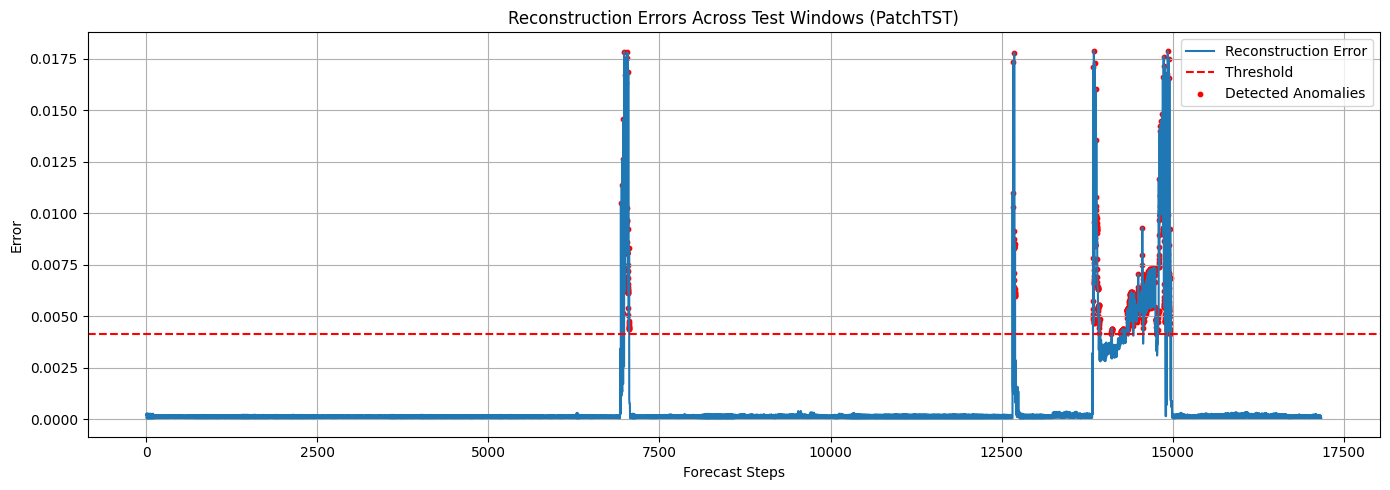

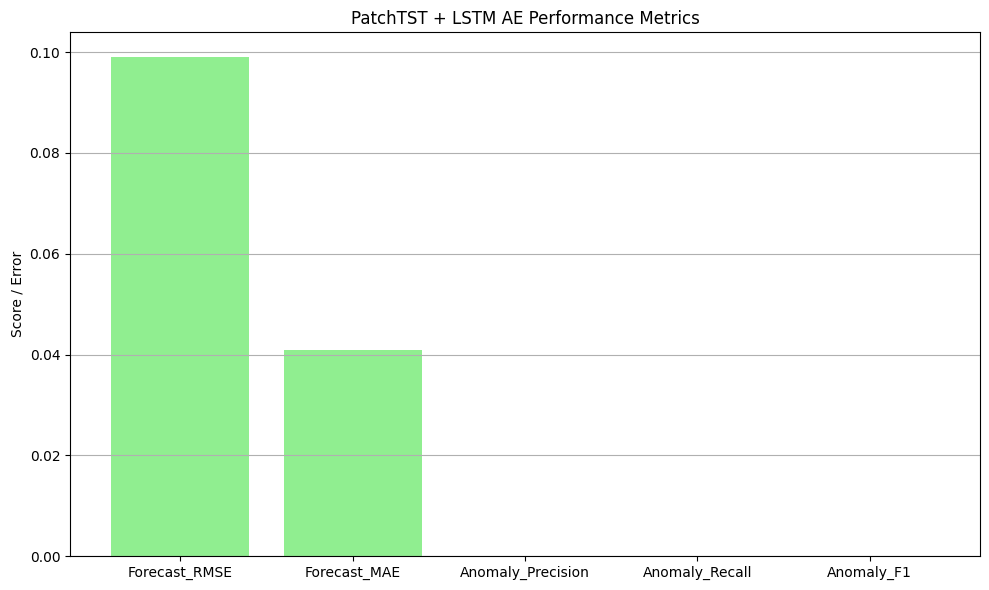

In [4]:
# ========================
# 10. EVALUATION
# ========================

# Forecasting metrics
y_pred_all = np.vstack(forecast_list)
y_true_all = np.vstack(true_windows)

forecast_rmse = np.sqrt(mean_squared_error(y_true_all.reshape(-1), y_pred_all.reshape(-1)))
forecast_mae = mean_absolute_error(y_true_all.reshape(-1), y_pred_all.reshape(-1))

print(f"\n📈 Forecasting Evaluation on Test:")
print(f"RMSE: {forecast_rmse:.5f}")
print(f"MAE:  {forecast_mae:.5f}")

# Anomaly detection metrics
all_true_labels = np.zeros_like(np.hstack(anomaly_flags_list))  # Assume all normal
all_detected = np.hstack(anomaly_flags_list)

precision = precision_score(all_true_labels, all_detected, zero_division=0)
recall = recall_score(all_true_labels, all_detected, zero_division=0)
f1 = f1_score(all_true_labels, all_detected, zero_division=0)

print(f"\n📈 Anomaly Detection Evaluation:")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")

# ========================
# 11. SAVE METRICS
# ========================

metrics_results = {
    "Model": "PatchTST + LSTM AE",
    "Forecast_RMSE": forecast_rmse,
    "Forecast_MAE": forecast_mae,
    "Anomaly_Precision": precision,
    "Anomaly_Recall": recall,
    "Anomaly_F1": f1
}

metrics_df = pd.DataFrame([metrics_results])
metrics_df.to_csv("metrics_patchtst_pipeline.csv", index=False)
print("\n✅ Metrics saved to 'metrics_patchtst_pipeline.csv'.")

# ========================
# 12. PLOTS
# ========================

# Plot Reconstruction Errors
plt.figure(figsize=(14,5))
all_errors = np.hstack(reconstruction_errors)
plt.plot(all_errors, label='Reconstruction Error')
plt.axhline(np.percentile(all_errors, THRESHOLD_PERCENTILE), color='red', linestyle='--', label='Threshold')
plt.scatter(np.where(all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)), 
            all_errors[all_errors > np.percentile(all_errors, THRESHOLD_PERCENTILE)],
            color='red', label='Detected Anomalies', s=10)
plt.title("Reconstruction Errors Across Test Windows (PatchTST)")
plt.xlabel("Forecast Steps")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_patchtst.png")
plt.show()

# Plot Metrics
metric_names = ["Forecast_RMSE", "Forecast_MAE", "Anomaly_Precision", "Anomaly_Recall", "Anomaly_F1"]
metric_values = [forecast_rmse, forecast_mae, precision, recall, f1]

plt.figure(figsize=(10,6))
plt.bar(metric_names, metric_values, color='lightgreen')
plt.title("PatchTST + LSTM AE Performance Metrics")
plt.ylabel("Score / Error")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("metrics_bar_chart_patchtst.png")
plt.show()